In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.stats
sns.set_theme(style="whitegrid")

In [2]:
# read in tweet data and congressmember data
df = pd.read_csv('data/tweet_data.csv')
congress_info = pd.read_csv('data/congressmember_data.csv')

In [3]:
# calculate ratio
df['ratio'] =  ((df['retweeted__quote_count'] + df['retweeted__reply_count'] - df['retweeted__retweet_count']) /
                (df['retweeted__retweet_count'] + df['retweeted__quote_count'] + df['retweeted__reply_count']))

In [4]:
# calculate the mean, median, and standard error of the mean for each MoC
stats = df.groupby('retweeted__user__name')['ratio'].aggregate([np.mean, np.median, scipy.stats.sem])

/home/mab1242/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mab1242/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# select the top 20 most ratioed MOCs
users = list(reversed(stats.sort_values('median', ascending=False)[:20].index.tolist()))

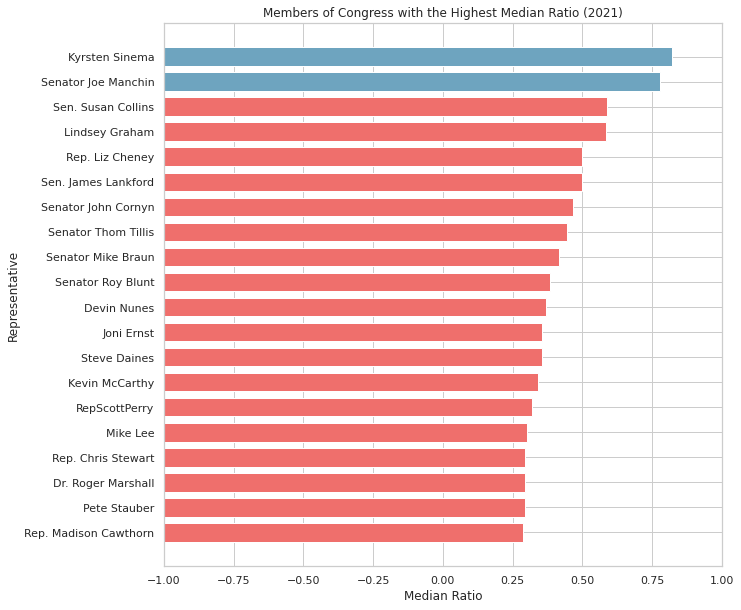

In [6]:
# for the top 20 MoCs, calculate
plt.figure(figsize=(10, 10))
for i, person in enumerate(users):
    if person == 'Kyrsten Sinema' or person == 'Senator Joe Manchin':
        plt.barh(y=i, height=.75, width=1 + stats.loc[person]['median'], left=-1, color='#6EA4BF')
    else:
        plt.barh(y=i, height=.75, width=1 + stats.loc[person]['median'], left=-1, color='#EF6F6C')
    
plt.yticks(range(len(users)), users)
plt.xlim(-1, 1)
plt.title('Members of Congress with the Highest Median Ratio (2021)')
plt.ylabel('Representative')
plt.xlabel('Median Ratio')
plt.savefig('figures/bar_plot.png', dpi=600, bbox_inches="tight")

In [7]:
# join the max rows dataframe with the congress metadata
merged = pd.merge(df, congress_info, on='screen_name', how='inner')

(-1.0, 1.0)

<Figure size 720x1800 with 0 Axes>

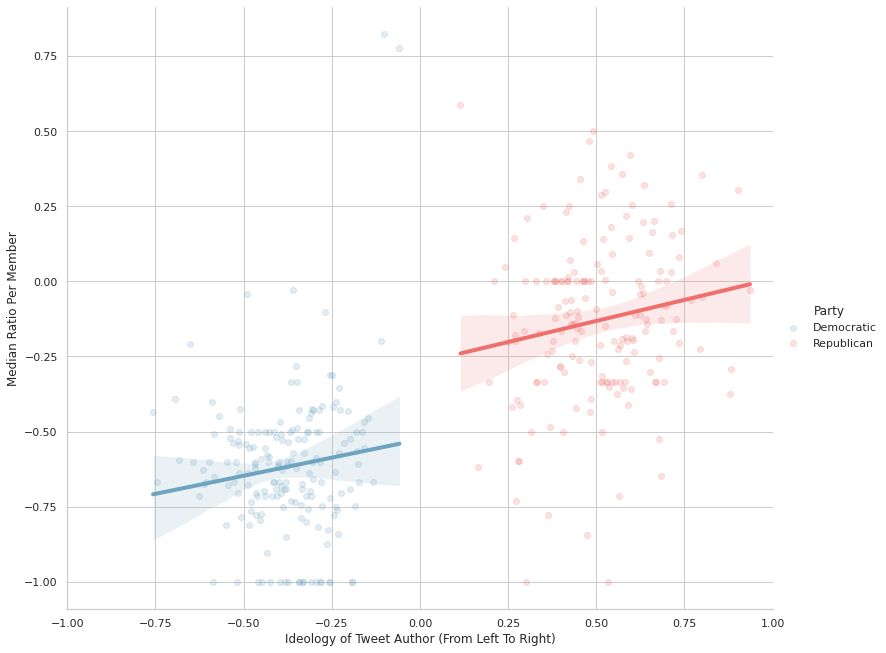

In [9]:
# rename data for pretty figs
data_to_output = merged.copy()
data_to_output['party'] = data_to_output['party'].replace({'Independent':'Democratic'})
data_to_output.rename({'ratio':'Median Ratio Per Member', 
                       'nominate_dim1':'Ideology of Tweet Author (From Left To Right)',
                       'party':'Party'
                      }, axis=1, inplace=True)

# join party data
party = data_to_output.groupby('Ideology of Tweet Author (From Left To Right)')['Median Ratio Per Member'].median().reset_index()
data_to_output = pd.merge(party, data_to_output[['Ideology of Tweet Author (From Left To Right)', 'Party']].drop_duplicates(),
                          on='Ideology of Tweet Author (From Left To Right)')

# plot the linear regression separated by party
ax = plt.figure(figsize=(10, 25))
g = sns.lmplot(data=data_to_output, y='Median Ratio Per Member', x='Ideology of Tweet Author (From Left To Right)', truncate=True,
               scatter_kws={'alpha':0.2, 'marker':','}, line_kws={'linewidth':4}, hue='Party', palette=['#6EA4BF', '#EF6F6C'], 
               height=9, aspect=1.2) 

plt.xlabel('Ideology of Tweet Author (From Left To Right)')
plt.savefig('figures/linear_regression.png', dpi=600, bbox_inches="tight")
plt.xlim(-1, 1)